In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import joblib
from profanity_check import predict, predict_prob
from langdetect import detect
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk import word_tokenize
from nltk import sentiment
from flair.models import TextClassifier
from flair.data import Sentence
import pyphen
import pronouncing
import os, glob, requests, uuid, json, re, random, itertools, math

In [2]:
train = pd.read_csv("Lyrics-Genre-Train.csv")
test = pd.read_csv("Lyrics-Genre-Test-GroundTruth.csv")

In [3]:
train

,Song,Song year,Artist,Genre,Lyrics,Track_id
0,forest-enthroned,2007,catamenia,Metal,"I am a night in to the darkness, only soul los...",18096
1,superhero,2010,aaron-smith,Hip-Hop,"Yeah\nSometimes, i just wanna fly away.\nThey ...",22724
2,chicago-now,2007,fall,Metal,Do you work hard?\nDo you work hard?\nYou don'...,24760
3,the-secret,2007,geto-boys,Hip-Hop,You know what? I'm destined to be the last man...,24176
4,be-the-lake,2011,brad-paisley,Country,There ain't nothing that I would rather see\nT...,17260
...,...,...,...,...,...,...
18508,i-wish-he-didn-t-trust-me-so-much,2008,bobby-womack,R&B,I'm the best friend he's got\nI'd give him the...,12033
18509,i-totally-miss-you,2006,bad-boys-blue,Pop,"Bad Boys Blue\n""I Totally Miss You""\nI did you...",15987
18510,sorry-for-love,2002,celine-dion,Pop,Forgive me for the things\nThat I never said t...,2722
18511,cure-for-aids,2008,dan-bern,Indie,The day they found a cure for AIDS\nThe day th...,10221


### Genre distribution

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


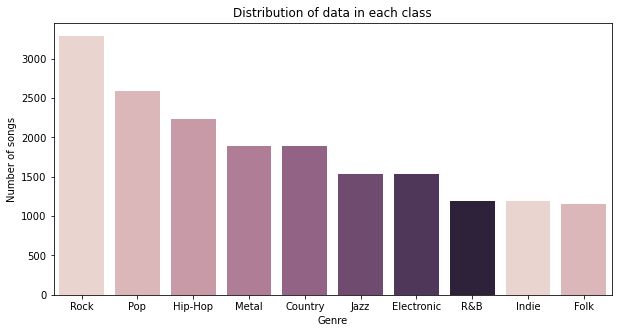

In [4]:
plt.figure(figsize = (10, 5))
sns.countplot(train.Genre, order = train.Genre.value_counts().index, palette = sns.cubehelix_palette(8))
plt.xlabel('Genre')
plt.title('Distribution of data in each class')
plt.ylabel('Number of songs')
plt.show()

### Year distribution

Text(0, 0.5, 'Song year')

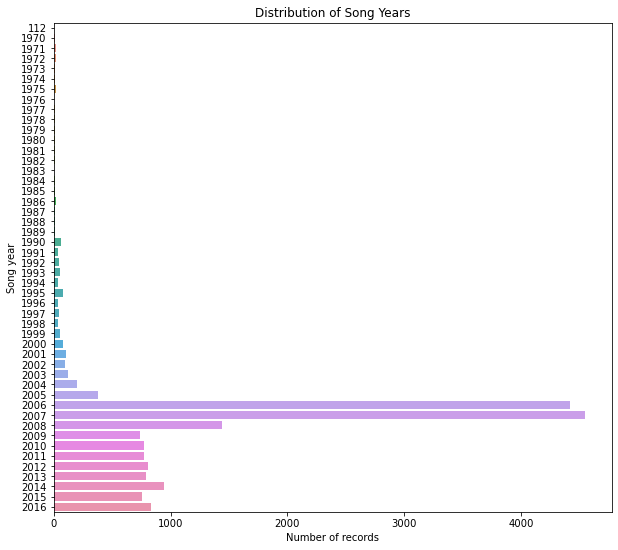

In [5]:
plt.figure(figsize = (10, 9))
sns.countplot(y = "Song year", data = train)
plt.title("Distribution of Song Years")
plt.xlabel("Number of records")
plt.ylabel("Song year")

### Top artists for each genre

In [6]:
# Rock
train[train.Genre == 'Rock']['Artist'].value_counts().head(5)

bob-dylan            19
conway-twitty        17
bruce-springsteen    17
b-b-king             15
elton-john           15
Name: Artist, dtype: int64

In [7]:
# Pop
train[train.Genre == 'Pop']['Artist'].value_counts().head(5)

bee-gees            51
barbra-streisand    41
american-idol       31
celine-dion         30
diana-ross          27
Name: Artist, dtype: int64

In [8]:
# Hip-Hop
train[train.Genre == 'Hip-Hop']['Artist'].value_counts().head(5)

chris-brown       63
eminem            53
busta-rhymes      42
chamillionaire    38
50-cent           32
Name: Artist, dtype: int64

In [9]:
# Metal
train[train.Genre == 'Metal']['Artist'].value_counts().head(5)

fall               38
fear-factory       18
anthrax            18
edguy              16
cannibal-corpse    16
Name: Artist, dtype: int64

In [10]:
# Country
train[train.Genre == 'Country']['Artist'].value_counts().head(5)

dolly-parton      116
eddy-arnold        72
bill-anderson      68
ferlin-husky       50
emmylou-harris     49
Name: Artist, dtype: int64

In [11]:
# Jazz
train[train.Genre == 'Jazz']['Artist'].value_counts().head(5)

dean-martin        124
ella-fitzgerald    123
frank-sinatra       71
aaron-neville       60
bing-crosby         54
Name: Artist, dtype: int64

In [12]:
# Electronic
train[train.Genre == 'Electronic']['Artist'].value_counts().head(5)

bjrthrk                    43
everything-but-the-girl    34
david-guetta               29
crduan-xshadows            28
faithless                  22
Name: Artist, dtype: int64

In [13]:
# R&B
train[train.Genre == 'R&B']['Artist'].value_counts().head(5)

babyface           142
brian-mcknight      91
aretha-franklin     70
anti-flag           66
al-green            54
Name: Artist, dtype: int64

In [14]:
# Indie
train[train.Genre == 'Indie']['Artist'].value_counts().head(5)

devendra-banhart      51
dar-williams          48
the-blood-brothers    37
frank-turner          36
city-and-colour       30
Name: Artist, dtype: int64

In [15]:
# Folk
train[train.Genre == 'Folk']['Artist'].value_counts().head(5)

celtic-woman        78
clannad             78
gordon-lightfoot    63
arrogant-worms      63
amos-lee            50
Name: Artist, dtype: int64

### Data Preprocessing

In [16]:
def text_preprocessing(text, lemmatize):
    if not isinstance(text, str):
        text = text.decode('ISO-8859-1')
    
    text = re.sub('[^a-zA-Z]', ' ', text) # Clear the special characters from our dataset
    text = text.lower() 
    text = text.split() 
    text = ' '.join(text)
    #print('\tClear Text.\n', text)

    # Tokenize
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    #print('\tTokenizing.\n', tokens)

    # Removing the stopwords
    stop = stopwords.words('english')
    tokens = [token for token in tokens if token not in set(stop)]
    #print('\tRemoving the stopwords.\n', tokens)
    
    # Remove words shorter than 3 characters
    tokens = [token for token in tokens if len(token) >= 2]
    #print('\tRemoving the words shorter than 3 characters\n', tokens)
    

    if lemmatize:
        # Lemmatize
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
        #print('\tLemmatizing.\n', tokens)
    else:
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(word) for word in tokens]
    
    # Preprocessed text
    tokens = ' '.join(tokens)
    
    return tokens

train['clean_lyrics'] = [text_preprocessing(doc, True) for doc in train.Lyrics]
test['clean_lyrics'] = [text_preprocessing(doc, True) for doc in test.Lyrics]

### How many songs contain profanity?

In [17]:
train["has_swearing"] = train.clean_lyrics.apply(lambda x: 1 if predict([x]) == 1 else 0)
test["has_swearing"] = test.clean_lyrics.apply(lambda x: 1 if predict([x]) == 1 else 0)

There are 3519 songs that contain profanity


<AxesSubplot:title={'center':'Percentage of genres that contain profanity'}, ylabel='Genre'>

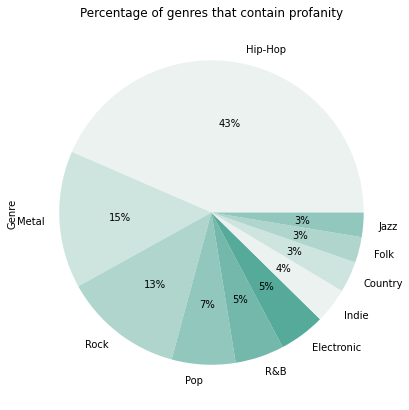

In [78]:
print(f"There are {train[train.has_swearing==1].shape[0]} songs that contain profanity")
plt.figure(figsize = (7, 7))
plt.title("Percentage of genres that contain profanity")
colors = sns.color_palette('light:#5A9')
train[train.has_swearing==1]['Genre'].value_counts().plot(kind='pie', autopct='%1.0f%%', colors = colors)

### Most common words for each genre

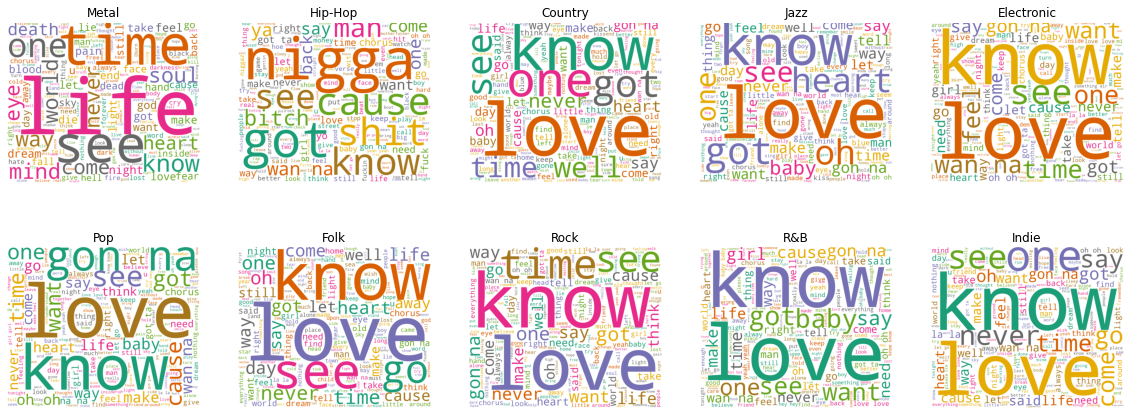

In [81]:
plt.figure(figsize=(20, 20))
for i, gen in enumerate(train.Genre.unique()):
    word_string = " ".join(train.clean_lyrics[train.Genre == gen])
    wordcloud = WordCloud(background_color = "white", colormap = "Dark2", width = 1200, 
                              height = 1000).generate(word_string)
    plt.subplot(5, 5, i+1)
    plt.imshow(wordcloud)
    plt.title(gen)
    plt.axis('off')
plt.show()


### Number of words per song

In [20]:
train['num_words'] = train['clean_lyrics'].map(len)
test['num_words'] = test['clean_lyrics'].map(len)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Number of words present in songs')

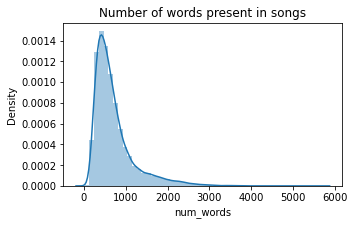

In [21]:
plt.figure(figsize = (5, 3))
sns.distplot(train.num_words, kde = True).set_title("Number of words present in songs")

### Sentiment Analysis

In [22]:
sia = TextClassifier.load('en-sentiment')
def sentiment_prediction(x):
    sentence = Sentence(x)
    sia.predict(sentence)
    score = sentence.labels[0]
    if "POSITIVE" in str(score):
        return "positive"
    elif "NEGATIVE" in str(score):
        return "negative"
    else:
        return "neutral"
    
train["sentiment"] = train["clean_lyrics"].apply(sentiment_prediction)
test['sentiment'] = test['clean_lyrics'].apply(sentiment_prediction)

2022-01-20 19:41:20,218 loading file C:\Users\Raluca\.flair\models\sentiment-en-mix-distillbert_4.pt


Text(0.5, 1.0, 'Songs sentiments')

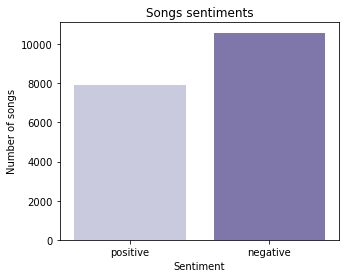

In [23]:
plt.figure(figsize = (5, 4))
sns.countplot(x = "sentiment", data = train, palette = "Purples")
plt.xlabel("Sentiment")
plt.ylabel("Number of songs")
plt.title("Songs sentiments")

### Language detection

In [24]:
languages_train = []

for i in train.Lyrics:
    try:
        lang = detect(str(i))
    except:
        lang = 'error'
    languages_train.append(lang)

languages_test = []

for i in test.Lyrics:
    try:
        lang = detect(str(i))
    except:
        lang = 'error'
    languages_test.append(lang)

In [25]:
train['language'] = languages_train
test['language'] = languages_test

train['language'].value_counts()

en    18500
es        3
fr        3
id        2
it        2
hr        1
cy        1
et        1
Name: language, dtype: int64

#### Converting genres labels to encoding representations

In [28]:
genre_map = {'Folk': 0, 'Country': 1, 'Jazz': 2, 'Hip-Hop': 3, 'R&B': 4, 
             'Rock': 5, 'Metal': 6, 'Pop': 7, 'Indie': 8, 'Electronic': 9}

train['Genre_Encoded'] = train['Genre'].map(genre_map)
test['Genre_Encoded'] = test['Genre'].map(genre_map)

### Creating other new features
- number of syllables
- number of rhymes

In [54]:
def syllables_average(text):
    dictionary = pyphen.Pyphen(lang = 'en')
    lines = text.split('\n')
    average_syllables = 0

    for ver in lines:
        text = ver.lower()
        text = re.sub('[/(){}[]|@,;]!?:.,', ' ', text)
        text = re.sub('[^0-9a-z #+_]', '', text)
        text = ' '.join(text.split())
        ts = text.split()
        ts = text.lower()
        s = [dictionary.inserted(ts).split('-') for token in ts]
        s = list(itertools.chain.from_iterable(s))

        average_syllables += len(s)

    average_syllables /= len(lines)

    return round(average_syllables)

def rhymes_number(verses):
    def last_two_letters(words):
        last_2_letters = []
        if words[-2:-1][0][-1].isnumeric():
            last_2_letters.append(words[-2:-1][0][:-1])
        else:
            last_2_letters.append(words[-2:-1][0])
        if words[-1:][0][-1].isnumeric():
            last_2_letters.append(words[-1:][0][:-1])
        else:
            last_2_letters.append(words[-1:][0])
        return last_2_letters

    dictionary = pyphen.Pyphen(lang='en')
    punctuation = '''!()-[]{};:'", <>./?@#$%^&*_~'''

    for line in verses:  
        if line in punctuation:  
            verses = verses.replace(line, " ")  
    lasts = []
    for verse in verses.split('\n'):
        if len(verse.split()) > 0:
            last_word = verse.split()[-1]
            try:
                lasts.append((dic.inserted(last_word).split('-'), last_two_letters(pronouncing.phones_for_word(last_word)[0].split())))
            except:
                lasts.append((last_word, 'NaN'))
            
    rhyme_no = 0
    for i in range(len(lasts) - 1):
        for j in range(i, len(lasts)):
            if lasts[i][1] == lasts[j][1]:
                rhyme_no += 1
            elif lasts[i][0][-1] == lasts[j][0][-1]:
                rhyme_no += 1
            elif ''.join(lasts[i][0])[-2:] == ''.join(lasts[j][0])[-2:]:
                rhyme_no += 1            
                
    return rhyme_no

def extract_metadata(data, dataframe = True):
    dictionary = {'Genre': [], 'Avg_Syllables': [], 
                            'Rhymes': [], 'Words': [], 'Verses': []}

    for line in data.iterrows():
        text = line[1]['Lyrics']
        syl_avg = syllables_average(text)
        rhymes_num = rhymes_number(text)
        text = line[1]['Lyrics'].lower()
        text = re.sub('[/(){}[]|@,;]!?:.,', ' ', text)
        text = re.sub('[^0-9a-z #+_]', '', text)
        text = ' '.join(text.split())
        words_num = len(text.split())
        verse_num = len(line[1]['Lyrics'].split('\n'))
        dictionary['Genre'].append(row[1]['Genre'])
        dictionary['Avg_Syllables'].append(syl_avg)
        dictionary['Rhymes'].append(rhymes_num)
        dictionary['Words'].append(words_num)
        dictionary['Verses'].append(verse_num)
    if dataframe == True:
        return pd.DataFrame(dictionary)
    return dictionary

train_metainformation = extract_metadata(train)
test_metainformation = extract_metadata(test)

In [74]:
train_meta = train_metainformation.copy()
train_meta['has_swearing'] = train['has_swearing']
train_meta['sentiment'] = train['sentiment']
train_meta['year'] = train['Song year']
train_meta['lyrics'] = train['clean_lyrics']
test_meta = test_metainformation.copy()
test_meta['has_swearing'] = test['has_swearing']
test_meta['sentiment'] = test['sentiment']
test_meta['year'] = test['Song year']
test_meta['lyrics'] = test['clean_lyrics']

In [75]:
sentiment_map = {'negative': 0, 'positive': 1}

train_meta['sentiment'] = train_meta['sentiment'].map(sentiment_map)
train_meta['Genre'] = train_meta['Genre'].map(genre_map)
test_meta['sentiment'] = test_meta['sentiment'].map(sentiment_map)
test_meta['Genre'] = test_meta['Genre'].map(genre_map)

### Conclusion

We have 2 types of datasets that we'll experiment with:
- one dataset that contain the preprocessed data
- one dataset with meta information about the songs: rhyme, syllables, sentiment, profanity

We'll save thus both of these datasets in order to continue with the Machine Learning approaches.

In [76]:
train.to_csv("final_train.csv", index = False)
test.to_csv("final_test.csv", index = False)
train_meta.to_csv("meta_train.csv", index = False)
test_meta.to_csv("meta_test.csv", index = False)

In [82]:
train_meta

,Genre,Avg_Syllables,Rhymes,Words,Verses,has_swearing,sentiment,year,lyrics
0,6,463,54,114,10,0,1,2007,night darkness soul lost walk throught night f...
1,3,2123,189,466,19,0,0,2010,yeah sometimes wan na fly away say skate surf ...
2,6,50,434,66,29,0,1,2007,work hard work hard chicago work hard try hard...
3,3,206,1484,434,54,1,0,2007,know destined last man standin carefully mappi...
4,1,201,324,187,25,0,0,2011,nothing would rather see drying dock thinking ...
...,...,...,...,...,...,...,...,...,...
18508,4,83,1127,286,47,0,0,2008,best friend got give shirt back know trust lif...
18509,7,100,1175,214,48,0,0,2006,bad boy blue totally miss wrong foolish heart ...
18510,7,83,1595,242,56,0,0,2002,forgive thing never said forgive knowing right...
18511,8,162,299,179,24,0,0,2008,day found cure aid day found cure aid everybod...
